In [1]:
%matplotlib widget

In [2]:
from ipywidgets import interactive, widgets
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.widgets import PolygonSelector
from matplotlib.backend_bases import MouseEvent
import json
import textwrap
import ast
from camera import Camera
import pickle as pkl
from dorna_vision.draw import *
from dorna_vision.util import *
from detect import *

from dorna2 import Dorna


class default_widget(object):
    """docstring for ClassName"""
    def __init__(self,):
        super(default_widget, self).__init__()
        continuous_update = False
        style={'description_width': '150px'}
        widgets.IntText(value=7, description='Any:', disabled=False)
        self.widget_helper = {
            "xyz_label": widgets.HTML(value="Convert pixel coordinates to its 3D spatial values based on the predefined reference frame.", layout={'width': '99%'}, style=style),
            "xyz_width": widgets.IntText(value=10, placeholder=10, description='Width (pxl)', disabled=False, style=style),
            "xyz_height": widgets.IntText(value=10, placeholder=10, description='Height (pxl)', disabled=False, style=style),
            "xyz_xyz": widgets.Text(value='[0, 0, 0]', placeholder='[0, 0, 0]', description='Result (mm)', disabled=True, style=style),
            "xyz_convert": widgets.Button( description='Convert', disabled=False, button_style="", tooltip='Convert'),

        }

        self.widget_init = {
            "camera_setup_label": widgets.HTML(value="<ul><li><strong>Eye-in-hand</strong>: When the camera is mounted on the robot, input the robot's IP address to synchronize the 3D data with the robot.</li><li><strong>Eye-to-hand</strong>: If the camera is stationary, leave the robot's IP address field blank.</li></ul>", layout={'width': '99%'}, style=style),
            "camera_setup_type": widgets.Dropdown(value=0, options=[('Eye-in-hand', 0), ('Eye-to-hand', 1),], description='Mounting setup', continuous_update=continuous_update, style=style),
            "camera_setup_robot_ip": widgets.Text(value='localhost', placeholder='localhost', description='Robot IP address', disabled=False, style=style),
            "frame_label": widgets.HTML(value="Specify the reference frame based on the camera's setup:    <ul> <li>If the camera is attached to the robot (eye-in-hand), set it relative to the robot's base frame.</li> <li>If the camera is fixed (eye-to-hand), set it relative to the camera frame.</li> </ul> All measurements will be reported concerning this selected frame.", layout={'width': '99%'}, style=style),
            "frame_value": widgets.Text(value='[0, 0, 0, 0, 0, 0]', placeholder='[0, 0, 0, 0, 0, 0]', description='Frame', disabled=False, style=style),
            "ml_detection_label": widgets.HTML(value="Specify the path to the model, for any ML-based object detection.", layout={'width': '99%'}, style=style),
            "ml_detection_path": widgets.Text(value='', placeholder='Path to the detection model file (*.pkl), e.g., ai_models/test.pkl.', description='Detection model path', disabled=False, layout={'width': '99%'}, style=style),
            "init": widgets.Button( description='Initialize Parameters', disabled=False, tooltip='Initialize Parameters', button_style="success"), 
        }
        self.widget_input = {
            "plane_label": widgets.Label(value="Select 3 points relative to the oriented bounding box to define a hyperplane and determine the 6D pose of the detected item.", layout={'width': '99%'}, style=style),
            "plane_enb": widgets.Checkbox(value=False, description='Apply the 6D-pose', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "plane_value": widgets.Text(value="[]", placeholder='[]', description='Plane', disabled=True, layout={'width': '99%'}, style=style),
            
            "color_label": widgets.Label(value="Apply a color mask to filter specific colors by adjusting hue, saturation, and value. Fine-tune these settings to isolate the desired color range for better detection results.", layout={'width': '99%'}, style=style),
            "color_enb": widgets.Checkbox(value=False, description='Enable color mask', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "color_h": widgets.IntRangeSlider(value=[60, 120], min=0, max=179, step=1, description='Hue', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "color_s": widgets.IntRangeSlider(value=[85, 170], min=0, max=255, step=1, description='Saturation', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "color_v": widgets.IntRangeSlider(value=[85, 170], min=0, max=255, step=1, description='Vue', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "color_inv": widgets.Checkbox(value=False, description='Invert color mask', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            "roi_label": widgets.Label(value="Select the region of interest where the detection method is applied. Use the blue polygon selector on the output image to define this area.", layout={'width': '99%'}, style=style),
            "roi_enb": widgets.Checkbox(value=False, description='Enable ROI', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "roi_value": widgets.Text(value='[]', placeholder='[]', description='ROI', disabled=True, layout={'width': '99%'}, style=style),
            "roi_inv": widgets.Checkbox(value=False, description='Invert region', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "roi_crop": widgets.Checkbox(value=False, description='Crop region', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            "intensity_label": widgets.Label(value="Adjust brightness and contrast if necessary to enhance image details. Use the sliders for optimal visibility and improved detection results.", layout={'width': '99%'}, style=style),
            "intensity_enb": widgets.Checkbox(value=False, description='Apply the intensity', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "intensity_a" : widgets.FloatSlider(value=1, min=0, max=4, step=0.01, description='Contrast', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "intensity_b" : widgets.IntSlider(value=0, min=-255, max=255, step=1, description='Brightness', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            "2d_range_label": widgets.Label(value="Apply 2D constraints on the detected item's oriented bounding box aspect ratio and area to refine detection accuracy.", layout={'width': '99%'}, style=style),
            "2d_range_enb": widgets.Checkbox(value=False, description='Apply the size constraints', continuous_update=continuous_update,layout={'width': '99%'}, style=style),
            "2d_range_aspect_ratio": widgets.FloatRangeSlider(value=[0, 1], min=0, max=1, step=0.01, description='Aspect ratio', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "2d_range_area_range": widgets.IntRangeSlider(value=[0, 100000], min=0, max=100000, step=100, description='Area (pxl X pxl)', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            "3d_range_label": widgets.Label(value="Apply 3D constraints to remove detected items outside the specified x, y, z range relative to the frame.", layout={'width': '99%'}, style=style),
            "3d_range_enb": widgets.Checkbox(value=False, description='Apply the spatial constraints', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "3d_range_x": widgets.IntRangeSlider(value=[250, 350], min=-1000, max=1000, step=1, description='x (mm)', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "3d_range_y": widgets.IntRangeSlider(value=[0, 50], min=-1000, max=1000, step=1, description='y (mm)', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "3d_range_z": widgets.IntRangeSlider(value=[0, 50], min=-1000, max=1000, step=1, description='z (mm)', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "3d_range_inv": widgets.Checkbox(value=False, description='Invert the range', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            "method_value": widgets.Dropdown(value=0, options=[('No detection', 0), ('Ellipse detection', 1), ('Polygon detection', 2), ('Contour detection', 3), ('Aruco detection', 4), ('OCR detection', 5)], description='Detection method', continuous_update=continuous_update, style=style),
    
            "m_elp_pf_mode": widgets.Checkbox(value=False, description='Auto detection', continuous_update=continuous_update,layout={'width': '99%'}, style=style),
            "m_elp_nfa_validation": widgets.Checkbox(value=True, description='False alarm validation', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_elp_min_path_length": widgets.IntSlider(value=50, min=1, max=1000, step=1, description='Min path length', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_elp_min_line_length": widgets.IntSlider(value=10, min=1, max=1000, step=1, description='Min line length', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_elp_sigma": widgets.IntSlider(value=1, min=0, max=20, step=0.1, description='Blur', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_elp_gradient_threshold_value": widgets.IntSlider(value=20, min=1, max=100, step=1, description='Gradient', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
    

            "m_poly_inv": widgets.Checkbox(value=True, description='Inverse', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_poly_type": widgets.Dropdown(value=0, options=[('0: Otsu (auto)', 0), ('1: Binary', 1), ('2: Gaussian', 2)], description='Type', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_poly_thr" : widgets.IntSlider(value=127, min=0, max=255, step=1, description='Threshold value', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_poly_blur": widgets.IntSlider(value=3, min=1, max=20, step=1, description='Smoothing blur', continuous_update=continuous_update, layout={'width': '99%'}, style=style),                    
            "m_poly_mean_sub": widgets.IntSlider(value=0, min=-200, max=200, step=1, description='Mean subtract', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_poly_side" : widgets.IntSlider(value=3, min=3, max=20, step=1, description='Sides', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            
            "m_cnt_inv": widgets.Checkbox(value=True, description='Inverse', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_cnt_type": widgets.Dropdown(value=0, options=[('0: Otsu (auto)', 0), ('1: Binary', 1), ('2: Gaussian', 2)], description='Type', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_cnt_thr" : widgets.IntSlider(value=127, min=0, max=255, step=1, description='Threshold value', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_cnt_blur": widgets.IntSlider(value=3, min=1, max=20, step=1, description='Smoothing blur', continuous_update=continuous_update, layout={'width': '99%'}, style=style),                    
            "m_cnt_mean_sub": widgets.IntSlider(value=0, min=-200, max=200, step=1, description='Mean subtract', continuous_update=continuous_update, layout={'width': '99%'}, style=style),

            "m_aruco_dictionary":widgets.Dropdown(value="DICT_6X6_250", options= ["DICT_4X4_50", "DICT_4X4_100", "DICT_4X4_250", "DICT_4X4_1000", "DICT_5X5_50", "DICT_5X5_100", "DICT_5X5_250", "DICT_5X5_1000", "DICT_6X6_50", "DICT_6X6_100", "DICT_6X6_250", "DICT_6X6_1000", "DICT_7X7_50", "DICT_7X7_100", "DICT_7X7_250", "DICT_7X7_1000", "DICT_ARUCO_ORIGINAL", "DICT_APRILTAG_16h5", "DICT_APRILTAG_25h9", "DICT_APRILTAG_36h10", "DICT_APRILTAG_36h11"], description='Dictionary', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_aruco_marker_length": widgets.FloatSlider(value=10, min=1, max=100, step=0.1, description='Marker length (mm)', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_aruco_refine":widgets.Dropdown(value="CORNER_REFINE_APRILTAG", options=["CORNER_REFINE_NONE", "CORNER_REFINE_SUBPIX", "CORNER_REFINE_CONTOUR", "CORNER_REFINE_APRILTAG"], description='Refinement', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "m_aruco_subpix": widgets.Checkbox(value=False, description='Sub pixel', continuous_update=continuous_update, layout={'width': '99%'}, style=style),            

            "m_ocr_conf" : widgets.FloatSlider(value=0.5, min=0.01, max=1, step=0.01, description='Confidence', continuous_update=continuous_update, layout={'width': '99%'}, style=style), 

            "m_od_conf" : widgets.FloatSlider(value=0.5, min=0.01, max=1, step=0.01, description='Confidence', continuous_update=continuous_update, layout={'width': '99%'}, style=style), 
            "m_od_cls" : widgets.Text(value="", placeholder='', description='Detection classes', disabled=False, layout={'width': '99%'}, style=style), 

            #"output_label": widgets.Label(value="Select the maximum number of elements to be detected in each inference round.", layout={'width': '99%'}, style=style),
            "output_max_det" : widgets.IntSlider(value=10, min=1, max=100, step=1, description='Max detections per run', continuous_update=continuous_update, layout={'width': '99%'}, style=style), 
            "output_shuffle": widgets.Checkbox(value=True, description='Shuffle return data', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
            "output_save": widgets.Checkbox(value=False, description='Save the annotated image in the "output/*.jpg"', continuous_update=continuous_update, layout={'width': '99%'}, style=style),
        }
        self.widget_trigger = {
            "color_picker": widgets.ColorPicker(concise=False, description='Color picker', value='blue', disabled=False, style={'text_width': '0'}),
            "color_hsv": widgets.Text(value='Hue = 119, Saturation = 255, Value = 255', placeholder='', description='', disabled=True,),            

            "source_value": widgets.Dropdown(value=0, options=[('Stereo camera', 0), ('File', 1)], description='Image source', continuous_update=continuous_update, style=style),
            "source_feed": widgets.Dropdown(value="color_img", options=[('Color image', "color_img")], description='Feed', continuous_update=continuous_update, style=style, layout={'visible': 'none'}),

            "s_file_value": widgets.Text(value='', placeholder='Path to the file (*.jpg, *.jpeg, *.png, *.tiff, ...).Ex: test.jpg', description='File path', disabled=False, layout={'width': '99%'}, style=style),            
            "s_apply": widgets.Button( description='Capture Image', disabled=True, button_style="success", tooltip='Capture Image', style=style),
            #"s_update": widgets.Button( description='', disabled=False, button_style="", tooltip='Update source list', icon='refresh', layout={'width': '50px'}),
            "s_save_path": widgets.Text(value='', placeholder='*.jpg', description='Save image as', disabled=False, layout={'width': '99%'}),            
            "s_save": widgets.Button( description='Save', disabled=False, button_style="", tooltip='Save as'),

            #"model_path": widgets.Text(value='', placeholder='/full_path/to_the/object_detection_model.pkl', description='Object Detection Model', disabled=False, layout={'width': '99%'}, style=style),            
            #"model_save": widgets.Button( description='Set', disabled=False, button_style="", tooltip='Set'),

            #"robot_ip": widgets.Text(value='', placeholder='192.168.254.10', description='Robot IP Address', disabled=False, layout={'width': '99%'}, style=style),            
            #"robot_connect": widgets.Button( description='Connect', disabled=False, button_style="", tooltip='Connect'),

            #"camera_robot_calibration": widgets.Textarea(value='[[0.00525873615, -0.999894519, 0.0134620306, 46.5174596], [0.999959617, 0.00535678348, -0.00735796480, 32.0776662], [0.00728773209, -0.0135001806, 0.999882310, -4.24772615], [0.0, 0.0, 0.0, 1.0]]', placeholder='[[0.00525873615, -0.999894519, 0.0134620306, 46.5174596], [0.999959617, 0.00535678348, -0.00735796480, 32.0776662], [0.00728773209, -0.0135001806, 0.999882310, -4.24772615], [0.0, 0.0, 0.0, 1.0]]', description='Camera & Robot Calibration Matrix', disabled=False, layout={'width': '99%'}, style=style),            

            "out_prm": widgets.Textarea(value='', placeholder='', description='API call', disabled=True,  rows=15, layout={'width': '99%'}, style={'description_width': '75px'}),
            "out_return": widgets.Textarea(value='', placeholder='', description='Return value', disabled=True, rows=5, layout={'width': '99%'}, style={'description_width': '75px'}),

            "close": widgets.Button( description='Exit App', disabled=False, button_style="danger", tooltip='Exit App', layout={'justify-content': 'flex-end'}),
        }

class Detection_app(object):
    """docstring for App"""
    def __init__(self, model_path=None, calibration_matrix=None, frame=None):
        super(Detection_app, self).__init__()
        self.retval ={}
        self.config = {}

        """out plot"""
        # close everything first
        plt.close('all')
        
        # Create an initial display with the original image
        fig, ax = plt.subplots(frameon=False)
        self.plt = {
            "out":{
                "fig": fig,
                "ax": ax,
                "img_plt": ax.imshow(cv.cvtColor(np.zeros((10, 10), dtype=np.uint8), cv.COLOR_BGR2RGB)),

        }}
        self.plt["out"]["fig"].canvas.header_visible = False
        self.plt["out"]["fig"].tight_layout()
        self.plt["out"]["ax"].axis('off')
        self.plt["out"]["img_plt"].set_visible(False)

        """widgets"""
        # widget
        self.widget_init = default_widget().widget_init
        self.widget_in = default_widget().widget_input
        self.widget_tr = default_widget().widget_trigger
        self.widget_helper = default_widget().widget_helper
        
        """accordion for adjust the image"""
        # adjust_image
        color_picker_box = widgets.HBox([self.widget_tr[k] for k in [key for key in self.widget_tr.keys() if key.startswith('color_')]])
        acc_adjust_img = widgets.Accordion()
        acc_adjust_img.children = [
            widgets.VBox([self.widget_tr["source_value"], self.widget_tr["s_file_value"]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('roi_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('intensity_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('color_')]]+[widgets.HTML("<hr>")]+[color_picker_box]),
        ]
        for i, title in enumerate(['Source', 'Region of Interest', 'Intensity', 'Color Mask']):
            acc_adjust_img.set_title(i, title)    

        """init vbox"""
        acc_init_vbox = widgets.Accordion()
        acc_init_vbox.children = [
            widgets.VBox([self.widget_init[k] for k in [key for key in self.widget_init.keys() if key.startswith('camera_setup_')]]),
            widgets.VBox([self.widget_init[k] for k in [key for key in self.widget_init.keys() if key.startswith('frame_')]]),
            widgets.VBox([self.widget_init[k] for k in [key for key in self.widget_init.keys() if key.startswith('ml_detection_')]]),
        ] 
        for i, title in enumerate(['1. Camera Mounting', '2. Frame', '3. AI Models']):
            acc_init_vbox.set_title(i, title)
        
        init_vbox = widgets.VBox([
            acc_init_vbox,
            widgets.HBox([self.widget_init[k] for k in [key for key in ["init"]]]),
        ])  


        """method vbox"""
        method_vbox = widgets.VBox([
            self.widget_in["method_value"],
            widgets.VBox([widgets.HTML("<hr>")]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('m_elp_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('m_poly_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('m_cnt_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('m_aruco_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('m_ocr_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('m_od_')]]),
        ], layout={'width': '100%'})        

        """plane"""
        # plane selector
        plane_plot = widgets.Output()
        with plane_plot:
            # init fig and ax
            fig, ax = self.plane_plt()
            self.plt["plane"] = {
                "fig": fig,
                "ax": ax
            }
            plt.show(self.plt["plane"]["fig"])  

        # init plane
        self.plane_value = poly_select(self.widget_in["plane_value"])

        # Initialize plane selector
        self.plane_selector = PolygonSelector(self.plt["plane"]["ax"], onselect=self.plane_value.onselect, useblit=True, props=dict(color='orange', linestyle='--'))
        plane_box = widgets.VBox([self.widget_in["plane_value"], plane_plot])

        """accordion for settings"""
        # acc setting
        acc_helper = widgets.Accordion()

        acc_helper.children = [
            widgets.VBox([self.widget_helper[k] for k in [key for key in self.widget_helper.keys() if key.startswith('xyz_')]]),
        ]

        for i, title in enumerate(["Pixel to 3D"]):
            acc_helper.set_title(i, title)  

        """accordion for settings"""
        # acc setting
        acc_setting = widgets.Accordion()
        acc_setting.children = [
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('2d_range_')]]),
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('3d_range_')]]),
            plane_box,
            widgets.VBox([self.widget_in[k] for k in [key for key in self.widget_in.keys() if key.startswith('output_')]]),
        ]

        for i, title in enumerate(["2D Limit ", "3D Limit", "6D Pose", "Output Format"]):
            acc_setting.set_title(i, title)    

        """method plot"""
        method_plt = widgets.Output(layout={'width': '100%'})
        with method_plt:
            # init fig and ax
            fig, ax = plt.subplots(frameon=False)
            self.plt["method"] = {
                "fig": fig,
                "ax": ax,
                "img_plt": ax.imshow(np.zeros((10, 10), dtype=np.uint8), cmap='gray')
            }
            self.plt["method"]["fig"].canvas.header_visible = False
            self.plt["method"]["fig"].tight_layout()
            self.plt["method"]["fig"].set_size_inches((4,3), forward=True)
            self.plt["method"]["img_plt"].set_visible(False)
            plt.show(self.plt["method"]["fig"])


        """result"""
        result_vbox = widgets.VBox([self.widget_tr[k] for k in [key for key in self.widget_tr.keys() if key.startswith('out_')]])

        """tab"""
        tabs = [
            init_vbox,
            acc_adjust_img,
            widgets.HBox([method_vbox, method_plt]),
            acc_setting,
            result_vbox,
            acc_helper,
        ]
        self.tab = widgets.Tab()
        self.tab.children = tabs

        # hide
        for i in range(1, len(self.tab.children)):
            self.tab.children[i].layout.display = 'none'
        
        self.tab.set_title(0, 'Initialization')
        self.tab.set_title(1, 'Image')
        self.tab.set_title(2, 'Detection')
        self.tab.set_title(3, 'Setting')
        self.tab.set_title(4, 'Result')
        self.tab.set_title(5, 'Helper Functions')
        
        # header
        header = widgets.HBox([
            self.widget_tr["s_apply"],
            self.widget_tr["close"],
        ])

        # display
        display(widgets.VBox([header, self.tab]))

        # init parameters
        self.widget_init["init"].on_click(self.init_parameter)


        """roi"""
        # init roi
        self.roi_value = poly_select(self.widget_in["roi_value"])

        # Initialize PolygonSelector
        self.roi_selector = PolygonSelector(self.plt["out"]["ax"], onselect=self.roi_value.onselect, useblit=True, props=dict(color='blue', linestyle='--'))

        # interactive for source
        interactive(self.hide_show_source, source_value=self.widget_tr["source_value"])

        # interactive for ip
        interactive(self.hide_show_ip, source_value=self.widget_init["camera_setup_type"])

        # interactive color_picker
        self.widget_tr["color_picker"].observe(self.hex_to_hsv, names='value')
        
        # capture
        self.widget_tr["s_apply"].on_click(self.capture_camera_data)

        # capture
        #self.widget_tr["s_update"].on_click(self.update_source_list)

        # save
        self.widget_tr["s_save"].on_click(self.save_as_source)

        # close
        self.widget_tr["close"].on_click(self.__del__)

        # pixel to xyz
        self.widget_helper["xyz_convert"].on_click(self.pixel_to_xyz)



    def __del__(self, b):
        # buttons
        self.widget_tr["close"].layout.display = "none"
        self.widget_tr["s_apply"].layout.display = "none"

        try:
            self.d.camera.close()
        except Exception as ex:
            pass

        try:
            self.d.close()
        except Exception as ex:
            pass
        
        # plot
        plt.close('all')

        # tabs
        self.tab.close()


    def init_parameter(self, b):
        # disable elements in init tab
        for k in self.widget_init.keys():
            self.widget_init[k].disabled = True
        self.widget_init["init"].layout.display = 'none'

        # data
        self.data = None
        
        # robot
        robot = None
        if self.widget_init["camera_setup_type"].value == 0:
            try:
                robot = Dorna()
                robot.connect(self.widget_init["camera_setup_robot_ip"].value)
            except Exception as ex:
                pass
        
        # frame
        try:
            frame = ast.literal_eval(self.widget_init["frame_value"].value)
            if len(frame) != 6:
                frame = [0, 0, 0, 0, 0, 0]
        except Exception as ex:
            frame = [0, 0, 0, 0, 0, 0]

        # camera
        camera = Camera()
        try:
            camera.connect()
        except Exception as ex:
            pass
        
        # detect
        self.d = Detection(camera, robot, frame)
        
        # ocr
        self.d.init_ocr()
        
        # ml_detection
        ml_detection_path = self.widget_init["ml_detection_path"].value
        if ml_detection_path:
            self.d.init_od(ml_detection_path) 
            self.widget_in["method_value"].options = list(self.widget_in["method_value"].options) + [("Object detection", 6)]

        # hide element in method
        for k in [key for key in self.widget_in.keys() if key.startswith('m_')]:
            self.widget_in[k].layout.display = 'none'

        # enable capture image
        self.widget_tr["s_apply"].disabled = False

        # show tabs
        for i in range(1, len(self.tab.children)):
            self.tab.children[i].layout.display = "flex"

        # interactive run with no changing data
        interactive(self._detect_pattern, **self.widget_in)

        # display plot
        self.plt["out"]["img_plt"].set_visible(True)



    def hex_to_hsv(self, change):
        # Remove '#' if present
        hex_color = change['new'].lstrip('#')

        # Convert hex to RGB
        rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

        # Normalize RGB values to the range [0, 1]
        normalized_rgb = tuple(value / 255.0 for value in rgb_color)

        # Convert RGB to HSV
        hsv_color = colorsys.rgb_to_hsv(*normalized_rgb)

        # Adjust HSV values to the common OpenCV conventions
        h = int(hsv_color[0] * 179)
        s = int(hsv_color[1] * 255)
        v = int(hsv_color[2] * 255)
        self.widget_tr["color_hsv"].value = f"Hue = {h}, Saturation = {s}, Value = {v}"

        # color
        self.widget_in["color_h"].value = [max(0, h-20), min(179, h+20)]
        self.widget_in["color_s"].value = [max(0, s-20), min(255, s+20)]
        self.widget_in["color_v"].value = [max(0, v-20), min(255, v+20)]

    
    def save_as_source(self, b):
        file_path = self.widget_tr["s_save_path"].value
        
        # opencv
        cv.imwrite(file_path, self.d.camera_data["color_img"])

        
    def open_pkl(self, file_path):
        with open(file_path, 'rb') as file:
            loaded_data = pkl.load(file)
        return loaded_data


    def pixel_to_xyz(self, b):
        width = self.widget_helper["xyz_width"].value
        height = self.widget_helper["xyz_height"].value
        xyz = self.d.pixel_to_xyz([width, height])
        self.widget_helper["xyz_xyz"].value = f"[{', '.join(f'{value:.1f}' for value in xyz)}]"


    def capture_camera_data(self, b):
        self.data = None
        if self.widget_tr["source_value"].value == 1: # read from file
            # file_path
            self.data = self.widget_tr["s_file_value"].value

        # call detect pattern
        kwargs = {k:self.widget_in[k].value for k in self.widget_in.keys()}
        self._detect_pattern(**kwargs)


    def update_source_list(self, b):
        all_device = self.d.camera.all_device()
        
        i = 0
        options = []
        for device in all_device:
            options.append((device["name"] +" (S/N: "+device["serial_number"], ")", i))
            i += 1
        options.append(('Image file', i))
        self.widget_tr["source_value"].options = options


    def hide_show_source(self, **kwargs):
        if kwargs["source_value"] == 1:
            self.widget_tr["s_file_value"].layout.display = "flex"
            #self.widget_tr["source_feed"].layout.display = "none"
        elif kwargs["source_value"] == 0:
            self.widget_tr["s_file_value"].layout.display = "none"
            #self.widget_tr["source_feed"].layout.display = "flex"


    def hide_show_ip(self, **kwargs):
        if kwargs["source_value"] == 0:
            self.widget_init["camera_setup_robot_ip"].layout.display = "flex"
        elif kwargs["source_value"] == 1:
            self.widget_init["camera_setup_robot_ip"].layout.display = "none"


    def plane_plt(self):
        # create
        fig, ax = plt.subplots(frameon=False)
        #fig.suptitle("Select 3 points of interest")
        fig.canvas.header_visible = False
        fig.tight_layout()
        
        # Set the height and calculate the width based on the golden ratio
        height = 1.0
        width = 1.0

        # Draw the ellipse in magenta
        ellipse = Ellipse((0, 0), 2 * width, 2 * height, linewidth=1, edgecolor='#FF00FF', facecolor='none')
        ax.add_patch(ellipse)

        # Draw the minimum bounding box around the ellipse in magenta
        min_bounding_box = plt.Rectangle((-width, -height), 2 * width, 2 * height, linewidth=1, edgecolor='#FF00FF', facecolor='none', label='Oriented Bounding Box')
        ax.add_patch(min_bounding_box)

        # Draw major and minor axes
        major_axis = plt.Line2D([0, width], [0, 0], color='red', linestyle='dashed', linewidth=1, label='Major Axis')
        minor_axis = plt.Line2D([0, 0], [0, height], color='green', linestyle='dashed', linewidth=1, label='Minor Axis')
        ax.add_line(major_axis)
        ax.add_line(minor_axis)

        # Plot the center of the rectangle in blue
        ax.plot(0, 0, marker='o', markersize=6, color='blue', label='Center')

        # Set axis limits with x and y axes twice as large
        ax.set_xlim(-2 * width, 2 * width)
        ax.set_ylim(-2 * height, 2 * height)

        # Display the legend
        ax.legend()

        # Set aspect ratio
        ax.set_aspect(1/1.68)

        # invert y
        ax.invert_yaxis()

        # Display the plot
        return fig, ax


    def api_call(self, prm):
        code = textwrap.dedent(
f"""# detection parameters
prm = {prm}

# create the Detection object
detection = Detection(camera=camera, robot=robot, **prm)

# call the detection
retval = detection.run()

# close when no longer needed
detection.close()""")
        return code
    

    def _detect_pattern(self, **kwargs):
        try:
            # adjust kwargs
            prm = {}

            # feed
            prm["feed"] = self.widget_tr["source_feed"].value
            
            # intensity
            prm["intensity"] = {"a": 1.0, "b": 0}
            if kwargs["intensity_enb"]:
                prm["intensity"] = {"a": kwargs["intensity_a"], "b": kwargs["intensity_b"]}
            
            # color
            prm["color"] = {"low_hsv": [0, 0, 0], "high_hsv": [255, 255, 255], "inv": 0}
            if kwargs["color_enb"]:
                prm["color"] = {"low_hsv": [kwargs[k][0] for k in ["color_h", "color_s", "color_v"]], "high_hsv": [kwargs[k][1] for k in ["color_h", "color_s", "color_v"]], "inv": kwargs["color_inv"]}
            
            # roi
            prm["roi"] = {"corners": [], "inv": 0, "crop": 0}
            if kwargs["roi_enb"]:
                prm["roi"] = {"corners": ast.literal_eval(kwargs["roi_value"]), "inv": kwargs["roi_inv"], "crop": kwargs["roi_crop"]}

            
            # detection
            prm["detection"] = {"cmd":None} 
            if kwargs["method_value"] == 1:
                prm["detection"] = {"cmd":"elp", "min_path_length": kwargs["m_elp_min_path_length"], "min_line_length": kwargs["m_elp_min_line_length"], "nfa_validation": kwargs["m_elp_nfa_validation"], "sigma": kwargs["m_elp_sigma"], "gradient_threshold_value": kwargs["m_elp_gradient_threshold_value"], "pf_mode": kwargs["m_elp_pf_mode"]}
            elif kwargs["method_value"] == 2:
                prm["detection"] = {"cmd":"poly", "type": kwargs["m_cnt_type"], "inv": kwargs["m_cnt_inv"], "blur": kwargs["m_cnt_blur"], "thr": kwargs["m_cnt_thr"], "mean_sub": kwargs["m_cnt_mean_sub"], "side": kwargs["m_poly_side"]}
            elif kwargs["method_value"] == 3:
                prm["detection"] = {"cmd":"cnt", "type": kwargs["m_cnt_type"], "inv": kwargs["m_cnt_inv"], "blur": kwargs["m_cnt_blur"], "thr": kwargs["m_cnt_thr"], "mean_sub": kwargs["m_cnt_mean_sub"]}
            elif kwargs["method_value"] == 4:
                prm["detection"] = {"cmd":"aruco", "dictionary": kwargs["m_aruco_dictionary"], "marker_length": kwargs["m_aruco_marker_length"], "refine": kwargs["m_aruco_refine"] , "subpix": kwargs["m_aruco_subpix"]}
            elif kwargs["method_value"] == 5:
                prm["detection"] = {"cmd":"ocr", "conf": kwargs["m_ocr_conf"]}
            elif kwargs["method_value"] == 6:
                cls_name =  [item.strip() for item in kwargs["m_od_cls"].split(',') if item.strip()]
                prm["detection"] = {"cmd":"od", "path": self.widget_init["ml_detection_path"].value, "conf": kwargs["m_od_conf"], "cls": cls_name}   

            #limit
            prm["limit"] = {"area":[], "aspect_ratio":[], "xyz":[], "inv":0}
            if kwargs["2d_range_enb"]:
                prm["limit"]["aspect_ratio"] = kwargs["2d_range_aspect_ratio"]
                prm["limit"]["area"] = kwargs["2d_range_area_range"]
            if kwargs["3d_range_enb"]:
                prm["limit"]["xyz"] = list(kwargs["3d_range_x"] + kwargs["3d_range_y"] + kwargs["3d_range_z"])
            if kwargs["3d_range_inv"]:
                prm["limit"]["inv"] = 1
            
            # plane
            prm["plane"] = []
            if kwargs["plane_enb"]:
                prm["plane"] = ast.literal_eval(kwargs["plane_value"])
            
            # output
            prm["output"] = { "max_det": kwargs["output_max_det"], "shuffle": kwargs["output_shuffle"], "save_img": kwargs["output_save"]}

            """hide and show inputs"""
            show_key = [[key for key in self.widget_in.keys() if key.startswith(term)] for term in ["m_nothing", "m_elp", "m_poly", "m_cnt", "m_aruco", "m_ocr", "m_od"]][kwargs["method_value"]]
            hide_key = [key for key in self.widget_in.keys() if key.startswith('m_') and key not in show_key] 
            for k in show_key:
                if self.widget_in[k].layout.display != "flex":
                    self.widget_in[k].layout.display = "flex"
            for k in hide_key:
                if self.widget_in[k].layout.display != "none":
                    self.widget_in[k].layout.display = "none"
            self.hide_key = hide_key
            self.show_key = show_key

            # run pattern detection
            self.prm = prm
            retval = self.d.run(data=self.data, **prm)
            self.data = dict(self.d.camera_data)
            
            # adjust the frame size
            self.plt["out"]["img_plt"].set_extent([0, self.d.camera_data[prm["feed"]].shape[1], self.d.camera_data[prm["feed"]].shape[0], 0])
            self.plt["method"]["img_plt"].set_extent([0, self.d.camera_data[prm["feed"]].shape[1], self.d.camera_data[prm["feed"]].shape[0], 0])

            # display thr
            if kwargs["method_value"] in [0, 1, 4, 5, 6]:      
                self.plt["method"]["img_plt"].set_visible(False)
                self.plt["method"]["ax"].axis('off')
            elif kwargs["method_value"] in [2, 3]: # polygon and contour
                self.plt["method"]["img_plt"].set_visible(True)
                self.plt["method"]["ax"].axis('on')
                self.plt["method"]["img_plt"].set_data(self.d.img_thr)


            # Update the existing plot
            self.plt["out"]["img_plt"].set_data(cv.cvtColor(self.d.img, cv.COLOR_BGR2RGB))

            # Redraw the plot
            self.plt["out"]["fig"].canvas.draw_idle()
            self.plt["method"]["fig"].canvas.draw_idle()
            
            # type retval
            json_str = json.dumps(retval)
            converted_retval = json.loads(json_str, parse_int=lambda x: int(x), parse_float=lambda x: float(x), parse_constant=lambda x: x, object_hook=lambda d: {k: 1 if v is True else 0 if v is False else v for k, v in d.items()}) 
            self.widget_tr["out_return"].value = json.dumps(converted_retval)
            self.retval = retval

            # api call
            self.widget_tr["out_prm"].value = self.api_call(prm)
            self.config = kwargs
            
        except Exception as ex:
            print(ex)
            pass

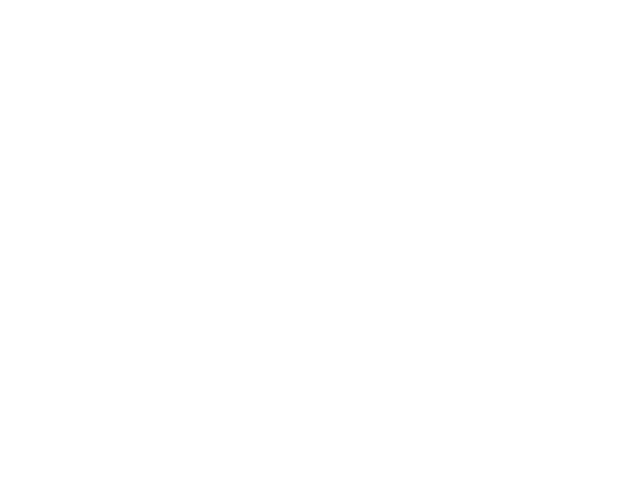

: 

In [ ]:
x = Detection_app()

In [ ]:
x.api_call(x.prm)
[285.3, 2.4, 0.3]
[282.3, -2.9, 0.6]
[286.3, -4.8, 0.1]

In [1]:
from detect import Detection
from camera import Camera
from dorna2 import Dorna
import time

# camera
camera = Camera()
camera.connect()

# robot
robot = Dorna()
robot.connect("192.168.254.18")

prm ={'feed': 'color_img',
 'intensity': {'a': 2.0, 'b': 1},
 'color': {'low_hsv': [10, 10, 10], 'high_hsv': [100, 100, 100], 'inv': 1},
 'roi': {'corners': [[10, 10], [10, 100], [100, 100], [100, 10]], 'inv': 0, 'crop': 0},
 'limit': {'area': [], 'aspect_ratio': [], 'xyz': [], 'inv': 0},
 'plane': [],
 'detection': {'cmd': "ocr", 'conf': 0.5},
 'output': {'max_det': 10, 'shuffle': True, 'save_img': True}}
d  = Detection(camera=camera, robot=robot, **prm)
s = time.time()
retval = d.run()
#retval = d.run(**prm)
print("overall: ", time.time() - s)

# close
camera.close()
robot.close()
print(retval)

overall:  1.0493872165679932
[]


In [14]:
import numpy as np

# Define your input points and their corresponding targets
train_points = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0]
])

train_targets = np.array([
    [0.0, 0.0, 0.0],
    [8.0, 0.0, 0.0],
    [0.0, 8.0, 0.0],
    [0.0, 1.0, 8.0]
])

# Append a column of ones to the input points to account for translation
train_points_augmented = np.hstack((train_points, np.ones((train_points.shape[0], 1))))

# Solve for the affine transformation matrix
# X * T = Y => T = (X.T * X)^-1 * X.T * Y
T, _, _, _ = np.linalg.lstsq(train_points_augmented, train_targets, rcond=None)

# Define a function to apply the transformation to new points
def map_point(point, T):
    point_augmented = np.append(point, 1)  # Add the homogeneous coordinate
    mapped_point = np.dot(point_augmented, T)
    return mapped_point

# Test the transformation on a new point
test_point = np.array([0.0, 0.0, 1.1])
predicted_xyz = map_point(test_point, T)

print("Predicted XYZ coordinates for test point:", predicted_xyz)


Predicted XYZ coordinates for test point: [1.69949396e-15 1.10000000e+00 8.80000000e+00]


In [15]:
T

array([[ 8.00000000e+00,  1.56012258e-16,  1.35144360e-15],
       [ 2.61999545e-15,  8.00000000e+00, -8.88178420e-16],
       [ 2.61999545e-15,  1.00000000e+00,  8.00000000e+00],
       [-1.18250103e-15, -8.88178420e-16, -1.15931653e-15]])

In [1]:
import numpy as np
import ncnn
import cv2 as cv

class ShuffleNetV2:
    def __init__(self, target_size=224, num_threads=3, use_gpu=False):
        self.target_size = target_size
        self.num_threads = num_threads
        self.use_gpu = use_gpu

        self.mean_vals = []
        self.norm_vals = [1 / 255.0, 1 / 255.0, 1 / 255.0]

        self.net = ncnn.Net()
        self.net.opt.use_vulkan_compute = self.use_gpu

        # https://github.com/miaow1988/ShuffleNet_V2_pytorch_caffe
        # models can be downloaded from https://github.com/miaow1988/ShuffleNet_V2_pytorch_caffe/releases
        # the ncnn model https://github.com/nihui/ncnn-assets/tree/master/models
        #self.net.load_param("C:/Users/hossein/Downloads/model_path_pt.param")
        self.net.load_param("C:/Users/hossein/.ncnn/models/shufflenet_v2_x0.5.param")
        
        self.net.load_model("C:/Users/hossein/Downloads/model_path_pt.bin")
        #self.net.load_model("C:/Users/hossein/.ncnn/models/shufflenet_v2_x0.5.bin")


    def __del__(self):
        self.net = None

    def __call__(self, img):
        img_h = img.shape[0]
        img_w = img.shape[1]

        mat_in = ncnn.Mat.from_pixels_resize(
            img,
            ncnn.Mat.PixelType.PIXEL_BGR,
            img.shape[1],
            img.shape[0],
            self.target_size,
            self.target_size,
        )
        mat_in.substract_mean_normalize(self.mean_vals, self.norm_vals)

        ex = self.net.create_extractor()
        ex.set_num_threads(self.num_threads)

        ex.input("data", mat_in)

        ret, mat_out = ex.extract("fc")

        # manually call softmax on the fc output
        # convert result into probability
        # skip if your model already has softmax operation
        softmax = ncnn.create_layer("Softmax")

        pd = ncnn.ParamDict()
        softmax.load_param(pd)

        softmax.forward_inplace(mat_out, self.net.opt)

        mat_out = mat_out.reshape(mat_out.w * mat_out.h * mat_out.c)

        cls_scores = np.array(mat_out)
        return cls_scores

In [4]:
import sys
import cv2
from ncnn.model_zoo import get_model
from ncnn.utils import print_topk



m = cv2.imread("C:/Users/hossein/Downloads/img_1726590775.jpg")

net = get_model("shufflenetv2", num_threads=4, use_gpu=False)

cls_scores = net(m)

print_topk(cls_scores, 3)

100%|██████████| 2/2 [00:00<00:00, 997.10KB/s]


100%|██████████| 5324/5324 [00:00<00:00, 12777.22KB/s]

421=0.214584
657=0.065248
478=0.051804


In [2]:
x = ShuffleNetV2()

In [3]:
img = cv.imread("C:/Users/hossein/Downloads/img_1726590775.jpg")
retval = x(img)

In [4]:
retval

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.